# Example: Center of Mass calculation

Prerequisites: 

 * a python3.6 virtualenv with all requirements installed
  * ``pip install -e .`` in your LiberTEM source dir
  * ``pip install hyperspy hyperspy_gui_ipywidgets notebook`` for additional dependencies
 * a HDF5 dataset

We disable threading in OpenBLAS because it would interfere with the dask multiprocessing and because OpenBLAS likes to call ``sched_yield`` for no discernable reason

In [2]:
%env OMP_NUM_THREADS=1
%env OPENBLAS_NUM_THREADS=1
%env OPENBLAS_NUM_THREADS=1

env: OMP_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1


In [3]:
%matplotlib nbagg

Import our dependencies. There may be some warnings about ``hyperspy_gui_traitui`` and so on which can be safely ignored (you do need ``hyperspy_gui_ipywidgets`` though):

In [4]:
from scipy.ndimage import measurements
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import hyperspy.api as hs

from libertem import api
from libertem.masks import gradient_x, gradient_y

This starts a local cluster that is accessible through ``ctx``. Starting several clusters in parallel is unproblematic because each cluster is rather lightweight and relies on the host file system for caching.

In [5]:
ctx = api.Context()

If you want to run this notebook, you may need to adjust the ``emd_path`` variable and ``hdf5path`` parameter here. This example uses a local HDF5 file as input dataset, but you can use the HDFS DataSet implementation if you want to use your cluster.

In [6]:
raw_path = '/media/uellue/Windows7_OS/Demo files/scan_11_x256_y256.raw'
emd_path = '/media/uellue/Windows7_OS/Demo files/scan_11_x256_y256.emd'

hdf5path = 'experimental/science_data/data'

# we keep this as an example how to load raw
raw_ds = ctx.load(
    'raw',
    path=raw_path,
    tileshape=(256, 256, 128, 128),
    scan_size=(256,256),
    dtype="float32",
    detector_size_raw=(130,128),
    crop_detector_to=(128,128)
)

ds = ctx.load(
    'hdf5',
    path=emd_path,
    ds_path=hdf5path,
    tileshape=(1,8,128,128)
)
(scan_y, scan_x, detector_y, detector_x) = ds.shape
mask_shape = np.array((detector_y, detector_x))

Now, we prepare for the actual computation. Center of Mass for a 2D image means multiplying each pixel's intensity with it's position and dividing by the sum of all pixel intensities. We do this separately for ``x`` and ``y`` axis by creating a gradient ``0..127`` for each axis, and a "all ones" mask for the sum of all pixels:

In [7]:
masks=[
    # summation of all pixels:
    lambda: np.ones(shape=mask_shape),
    
    # gradient from left to right
    lambda: gradient_x(*mask_shape),
    
    # gradient from top to bottom
    lambda: gradient_y(*mask_shape),
]
%time gradient_x(*mask_shape)

CPU times: user 450 µs, sys: 0 ns, total: 450 µs
Wall time: 384 µs


array([[  0.,   1.,   2., ..., 125., 126., 127.],
       [  0.,   1.,   2., ..., 125., 126., 127.],
       [  0.,   1.,   2., ..., 125., 126., 127.],
       ...,
       [  0.,   1.,   2., ..., 125., 126., 127.],
       [  0.,   1.,   2., ..., 125., 126., 127.],
       [  0.,   1.,   2., ..., 125., 126., 127.]], dtype=float32)

Now we set up the parameters for the job. 

In [8]:
job = ctx.create_mask_job(dataset=ds, factories=masks)

Now, we kick off the computation:

In [9]:
%time result = ctx.run(job)

CPU times: user 2.12 s, sys: 334 ms, total: 2.45 s
Wall time: 18.3 s


Let's show the result:

<IPython.core.display.Javascript object>


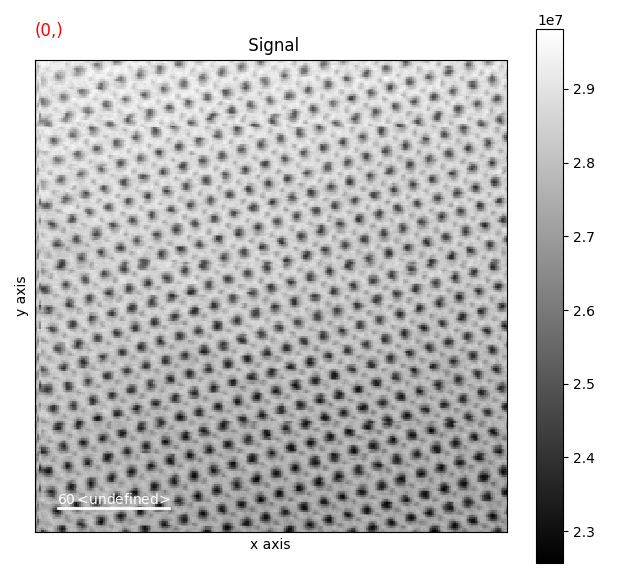

In [10]:
full_result = hs.signals.Signal2D(result)
full_result.axes_manager[0].name = "masks"
full_result.axes_manager[1].name = "x"
full_result.axes_manager[2].name = "y"
full_result.plot(navigator="slider")

Let's create another signal that contains the (x, y) pairs as signal for each scan position:

In [11]:
x_centers = np.divide(full_result.inav[1].data, full_result.inav[0].data)
y_centers = np.divide(full_result.inav[2].data, full_result.inav[0].data)
centers = hs.signals.Signal1D(np.dstack((x_centers, y_centers)))
centers

<Signal1D, title: , dimensions: (256, 256|2)>

Ok, now that we have our results, let's see how we compare to the ``scipy`` implementation. Let's use HyperSpy to load the dataset lazily (``optimize=False`` because of the lazy signal):

In [12]:
raw_data = hs.load(emd_path, lazy=True).as_signal2D(image_axes=(0, 1), optimize=False)

Let's have a look at one frame, plot it and see how the result compares to ours:

<IPython.core.display.Javascript object>


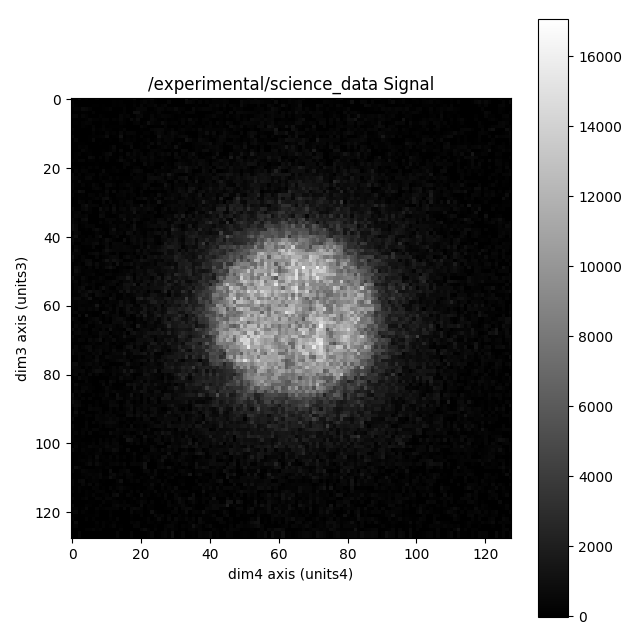

scipy center: x=64.278758, y=63.191338
our center:   x=64.278755, y=63.191326
difference from scipy: x=0.000003, y=0.000012


In [13]:
frame_coords = (0, 0)
frame = raw_data.inav[frame_coords]
frame.plot(navigator=None)
frame_data = frame.data.compute()
center_y, center_x = measurements.center_of_mass(frame_data)


# marker = hs.plot.markers.point(x=center_x, y=center_y, color='red')
# frame.add_marker(marker) # -> crashes for some reason


print("scipy center: x=%.6f, y=%.6f" % (center_x, center_y))
print("our center:   x=%.6f, y=%.6f" % (centers.inav[frame_coords].isig[0].data[0],
                                      centers.inav[frame_coords].isig[1].data[0]))
print("difference from scipy: x=%.6f, y=%.6f" % (
    (center_x - centers.inav[frame_coords].isig[0].data[0]),
    (center_y - centers.inav[frame_coords].isig[1].data[0])
))